# Toric Code Ground State on a Heavy Hexagonal Lattice
Daniel Ortmann, Florian Maier, Julius Feigl, Leonard Bleiziffer, Shivang Arora, Jan Wozniak
## Introduction:
The Toric code is an analytically solvable toy model, which shows very rich and interesting physics, such as a four-fold topological groundstate degeneracy on a torus and anyonic excitations. In 2021, Google published a paper realizing the ground state of the toric code model on their Sycamore chip (arXiv:2104.01180v1), which has a qubit layout perfectly suited for the toric code. In this project we examine how well the toric code ground state preparation is realizable on a non-ideal qubit layout such as the heavy hexagonal layout used by IBM. Next to the toric code ground state being scientifically interesting in itself, this project is also very exciting from the point of view of companies using a heavy hexagonal qubit layout in order to compare the realizability of the ground state compared to the optimal layout used by Google. Finally, the toric code is also an interesting model in terms of error correction since it can be used to encode e.g. 9 physical qubits in a logical qubit when using mixed boundary conditions as can be seen in arXiv:2104.01180v1.
## Idea
__naive solution: direct mapping without regard to topology__
__optimal: Use topology and optimize for topology, dont need full swaps, but can do things in parallel. W let the user specify the size of the toric code in y-direction (i.e. the number of plaquettes), but we only implemented the algorithm for a fixed size in x-direction (2 plaquettes). The size of the hardware is also flexible, the user just has to have a coupling map of the layout, it is only assumed that the layout is a heavy hex as usual for IBM machines.__
## Solution
### "Naive"/default solution
The naive solution does not use the underlying topology of the IBM quantum processor. It simply maps the qubits from the rectangular grid to physical qubits.
__scaling with longer chains, scaling with optimization with qiskit higher level, plots, can only optimize to linear__
### optimal solution
__optimize using topology, constant scaling in depth as long as we keep the number of plaquettes in x-direction at 2__
__proof that its correct ground state using expectation values done by measuring the ground state energy, i.e. the parity eigenvalue of each star and plaquette operator has to be one to be in groundstate__
__comprison google qubits to ibm qubit__
Quite well overlap of our result with Googles result and only constant scaling of circuit depth if we keep the number of plaquettes in x-direction at 2.

In [1]:
# Importing all the parts we will need.
from typing import List, Optional

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.visualization import plot_histogram
from qiskit.providers.fake_provider import *
import qiskit 
import numpy as np
import matplotlib.pyplot as plt
#from qiskit.test.mock import FakeWashington
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.providers.fake_provider import FakeWashington
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_gate_map
from qiskit import transpile
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import networkx as nx
import matplotlib.pyplot as plt
import copy

import warnings

warnings.filterwarnings("ignore")

import math

pi = math.pi

#globals
HARDWARE_TYPE = "IBM"

TRANSPILER_HANDLES_CNOT = True

# Your code here: Implementation of the naive solution

### Implementation of naive solution 

First, we define a class easily handling plaquettes, both, a rectangular and a heavy hexagonal lattice. 

In [2]:
class Plaquette:
    """Stores indices of qubits in one Plaquette and its own neighboring Plaquette objects."""

    def __init__(
        self,
        repres: int,
        left: int,
        right: int,
        bot: int,
        i_right: int,
        i_left: int,
        i_bot: int,
        top_neighbour: "Plaquette" = None,
        left_neighbour: "Plaquette" = None,
        right_neighbour: "Plaquette" = None,
        bot_neighbour: "Plaquette" = None,
    ):
        __slots__ = [
            "repres",
            "left",
            "right",
            "bot",
            "i_right",
            "i_left",
            "i_bot",
            "_top_neighbour",
            "_left_neighbour",
            "_right_neighbour",
            "_bot_neighbour",
        ]
        self.repres = repres
        self.left = left
        self.right = right
        self.bot = bot
        self.i_right = i_right
        self.i_left = i_left
        self.i_bot = i_bot
        self.top_neighbour = top_neighbour
        self.left_neighbour = left_neighbour
        self.right_neighbour = right_neighbour
        self.bot_neighbour = bot_neighbour

    @property
    def top_neighbour(self):
        return self._top_neighbour

    @top_neighbour.setter
    def top_neighbour(self, value: "Plaquette"):
        self._top_neighbour = value
        if value is not None:
            value._bot_neighbour = self

    @property
    def left_neighbour(self):
        return self._left_neighbour

    @left_neighbour.setter
    def left_neighbour(self, value: "Plaquette"):
        self._left_neighbour = value
        if value is not None:
            value._right_neighbour = self

    @property
    def right_neighbour(self):
        return self._right_neighbour

    @right_neighbour.setter
    def right_neighbour(self, value: "Plaquette"):
        self._right_neighbour = value
        if value is not None:
            value._left_neighbour = self

    @property
    def bot_neighbour(self):
        return self._bot_neighbour

    @bot_neighbour.setter
    def bot_neighbour(self, value: "Plaquette"):
        self._bot_neighbour = value
        if value is not None:
            value._top_neighbour = self

    @property
    def neighbours(self):
        return sum(
            x is not None
            for x in [
                self.top_neighbour,
                self.left_neighbour,
                self.right_neighbour,
                self.bot_neighbour,
            ]
        )

    @neighbours.setter
    def neighbours(self, value):
        raise AttributeError("Cannot set neighbours directly")

    def __repr__(self):
        return f"Plaquette(repr={self.repres}, left={self.left}, right={self.right}, bot={self.bot}), i_right={self.i_right}, i_left={self.i_left}, i_bot={self.i_bot})"

Next, a function which creates a list of plaquettes for an arbitrary rectangular lattice. From any list of plaquettes, we can create a quantum circuit using the appropriate function. 

In [3]:
def get_circuit_v2(plaquettes_x: int, plaquettes_y: int):
    """function that creates a list of Plaquette objects, based on the number of plaquettes in x and y direction in the google qubit layout
    param:
    plaquettes_x: number of plaquettes in x direction
    plaquettes_y: number of plaquettes in y direction
    return:
    list of Plaquette objects
    """
    repr_qubits = (
        np.array(
            [
                np.array(range(1, plaquettes_x + 1)) + i * (2 * plaquettes_x + 1)
                for i in range(0, plaquettes_y)
            ]
        )
        - 1
    )
    left_qubits = (
        np.array(
            [
                np.array(range(plaquettes_x + 1, 2 * (plaquettes_x) + 1))
                + i * (2 * plaquettes_x + 1)
                for i in range(0, plaquettes_y)
            ]
        )
        - 1
    )
    right_qubits = (
        np.array(
            [
                np.array(range(plaquettes_x + 2, 2 * (plaquettes_x) + 2))
                + i * (2 * plaquettes_x + 1)
                for i in range(0, plaquettes_y)
            ]
        )
        - 1
    )
    bottom_qubits = (
        np.array(
            [
                np.array(range(2 * (plaquettes_x) + 2, 3 * (plaquettes_x) + 2))
                + i * (2 * plaquettes_x + 1)
                for i in range(0, plaquettes_y)
            ]
        )
        - 1
    )
    plaquettes = np.zeros((plaquettes_x, plaquettes_y), dtype=Plaquette)
    for i in range(plaquettes_x):
        for j in range(plaquettes_y):
            plaquettes[i, j] = Plaquette(
                left=left_qubits[j, i],
                right=right_qubits[j, i],
                bot=bottom_qubits[j, i],
                repres=repr_qubits[j, i],
                i_right=None,
                i_left=None,
                i_bot=None,
            )
    for i in range(0, plaquettes_x):
        for j in range(0, plaquettes_y):
            if i > 0:
                plaquettes[i, j].left_neighbour = plaquettes[i - 1, j]
            if i < plaquettes_x - 1:
                plaquettes[i, j].right_neighbour = plaquettes[i + 1, j]
            if j < plaquettes_y - 1:
                plaquettes[i, j].bot_neighbour = plaquettes[i, j + 1]
            if j > 0:
                plaquettes[i, j].top_neighbour = plaquettes[i, j - 1]
    plaquettes = plaquettes.flatten()
    return plaquettes.tolist()


In [4]:
def circuit_from_plaquette(plaquettes):
    left_qubits = [plaquettes.left for plaquettes in plaquettes]
    right_qubits = [plaquettes.right for plaquettes in plaquettes]

    bot_qubits = [plaquettes.bot for plaquettes in plaquettes]
    repres_qubits = [plaquettes.repres for plaquettes in plaquettes]
    number_of_qubits = max(left_qubits + right_qubits + bot_qubits + repres_qubits) + 1
    circuit = QuantumCircuit(number_of_qubits)
    circuit.h(repres_qubits)
    circuit.cx(repres_qubits, left_qubits)
    circuit.cx(repres_qubits, right_qubits)

    rightmost_qubit = [plaquettes.right for plaquettes in plaquettes if plaquettes.right_neighbour is None]
    bottom_rightmost_qubit = [plaquettes.bot for plaquettes in plaquettes if plaquettes.right_neighbour is None]
    left_rightmost_qubit = [plaquettes.left for plaquettes in plaquettes if plaquettes.right_neighbour is None]

    last_left_qubit = [left_qubit for left_qubit in left_qubits if left_qubit not in left_rightmost_qubit]
    last_bot_qubit = [bot_qubit for bot_qubit in bot_qubits if bot_qubit not in bottom_rightmost_qubit]

    circuit.cx(last_left_qubit, last_bot_qubit)
    circuit.cx(rightmost_qubit, bottom_rightmost_qubit)
    
    return circuit

Now, we can calculate the scaling of the circuit depth for the naive solution. We use the depth of the transpiled circuit for the same quantum computer as we will use later for our implementation for easier comparison. We already use the maximal transpiler optimization.\
_the variable 'maximal_number_of_plaquettes' can be changed to see the evolution of circuit depth for higher numbers of plaquettes_

Text(0.5, 1.0, 'circuit depth for naive implementation for varying number of plaquettes in y direction')

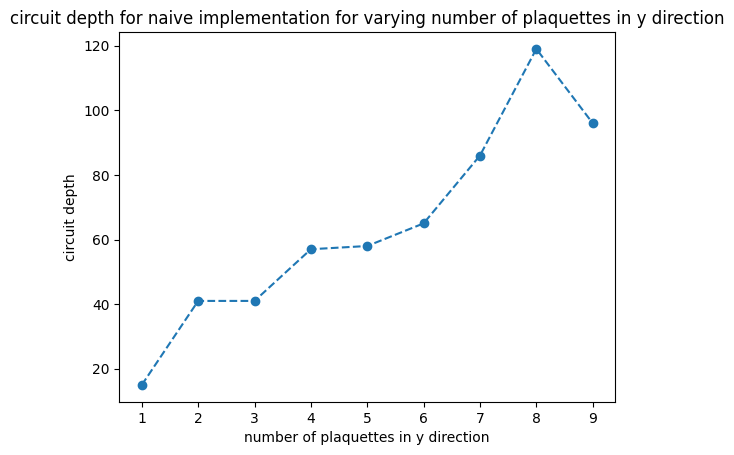

In [5]:
# calculate the circuit depth for a naive implementation for varying number of plaquettes in y direction
maximal_number_of_plaquettes = 10 

naive_circuit_depths = []
number_of_plaquettes = np.arange(1,maximal_number_of_plaquettes)
for i in number_of_plaquettes:
    plaquettes = get_circuit_v2(2,i)
    naive_circuit = circuit_from_plaquette(plaquettes)
    backend = FakeSherbrooke() # use Sherbrooke as backend 
    transpiled_ciruit = qiskit.transpile(naive_circuit,backend, optimization_level=3) # transpile the circuit for accurate 
    depth = transpiled_ciruit.depth()
    naive_circuit_depths.append(depth)

#plot the figure 
plt.figure()
plt.plot(number_of_plaquettes,naive_circuit_depths,marker='o',linestyle='--')
plt.xlabel('number of plaquettes in y direction')
plt.ylabel('circuit depth')
plt.title('circuit depth for naive implementation for varying number of plaquettes in y direction')

We see that the depth scales at least linearly with the number of plaquettes. Since the optimizer sometimes finds a better, and sometimes a worse solution, we cannot really determine the scaling.

### Our solution

Explain which paramateres can be changed in the code below, how to get different results.

#### improvement: using a topological mapping between a square and a heavy hexagonal lattice

Recognizing that we can topologically map the heavy hexagonal lattice to a square lattice, we can bring down the circuit depth to a constant value, with respect to the number of plaquettes in the y direction. In the first step, we can ignore the qubits which are inbetween the needed qubits by using swap gates. This is not yet optimal, but a step in the right direction.\
The image below shows a unit cell of a square lattice above, with the relevant qubits colored in, and the according mapping to the heavy hexagonal unit cell below. The qubits in purple are not needed, but ensure the required connectivity. 


![mapping](mapping.png "qubit mapping")

### optimal solution using circuit optimization

Recognizing that we do not need an entire swap gate to make sure the circuit works as supposed and using entanglement between the qubits, we can further optimize the depth of the circuit. The steps for a unit cell are as follows. 

In order to prepare the groundstate, we need to select a representative qubit for each plaquette, apply a Hadamard gate on all representatives, then a CNOT from the representative to the neighboring qubits in the plaquette and finally a CNOT from the left or right plaquette-qubit to the bottom qubit depending on the boundary (see also arxiv.org/abs/2104.01180 for more details why this prepares the toric code groundstate). Since the plaquette qubits are not directly connected in the heavy hexagon layout however, we need to apply the CNOTs via intermediate qubits. We found that the optimal way to do this is to apply a CNOT from the representative to the intermediate, then from the intermediate to the real target and then again from the representative to the intermediate (this saves two CNOT gates w.r.t. using SWAP gates). As seen in the gate sequence, this requires a depth of 7 layers if we not go beyond two plaquettes in x-direction (we can however have as many in y-deirection as fit on the hardware). 

These need to be made for all the plaquettes, except for the rightmost ones. For these, we have to add another CX gate between the qubits R and B. Since those qubits are not connected in the heavy hexagonal lattice, we need to add swap gates, increasing the depth. At this point we recognize that a slightly imporoved connectivity on one side of the chip would reduce the circuit depth to 8. Comparing this to the cited paper, which had a depth of 4 for a comparable circuit, we see that our depth overhead doubled for a not optimal topology. On the other hand this circuit depth is still managable for todays NISQ aera devices.\
Also, counting the qubits in a unit cell, we see that we need 7 qubits, compared to an optimal 4 qubits. Overall, this means we trade additional qubits for a lower circuit depth.\ 

![gates](gates1.png "gate sequence1")
![gates](gates2.png "gate sequence1")

On this basis, we 

In [7]:
def assign_neighbours(plaquet_list: list[Plaquette]) -> list[Plaquette]:
    """Assigns the neighbours of each plaquette in the list of plaquettes.

    Args:
        plaquet_list (list[Plaquette]): List of plaquettes

    Returns:
        list[Plaquette]: List of plaquettes with neighbours
    """
    length = range(len(plaquet_list))
    for i in length:
        for j in length:
            if plaquet_list[i].repres == plaquet_list[j].bot:
                plaquet_list[i].top_neighbour = plaquet_list[j]
            if plaquet_list[i].left == plaquet_list[j].right:
                plaquet_list[i].left_neighbour = plaquet_list[j]
            if plaquet_list[i].right == plaquet_list[j].left:
                plaquet_list[i].right_neighbour = plaquet_list[j]
            if plaquet_list[i].bot == plaquet_list[j].repres:
                plaquet_list[i].bot_neighbour = plaquet_list[j]
    return plaquet_list

def get_list_of_all_plaquets(coupling_map):
    """Returns a list of Plaquette objects for all possible plaquettes within the heavy hexagonal
       hardware layout specified by the coupling map.
       
    Args:
        coupling_map (list): List of lists of qubit indices, which are connected in the hardware layout.
           
    Returns:
        list: List of Plaquette objects for all possible plaquettes within the heavy hexagonal layout.
    """

    # Get indices of qubits, which can be representatives of plaquettes 
    # (i.e. have a downwards neighbor and the right neighbor is the next qubit)
    repr_indices = []
    for connection in coupling_map:
        if connection[1] > connection[0] + 2: # connection[0] has downwards neighbor
            neighbors = [c[1] for c in coupling_map if c[0] == connection[0]]
            for neighbor in neighbors:
                if neighbor == connection[0] + 1: # right neighbor of connection[0] is next qubit
                    repr_indices.append(connection[0])


    # Now go through the representatives and get the indices of the remaining qubits in the plaquette,
    # i.e. the left, right and bottom qubits as well as the intermediate qubits, which are inbetween 
    # the representative and the left, right and bottom qubits and create a plaquette object for each
    # representative
    plaquet_list = []  
    for repr_index in repr_indices:
        plaquet_indices = {'rep': repr_index}
        intermediate_indices = {}
        for connection in coupling_map:
            if connection[0] == repr_index:
                if connection[1] == repr_index + 1:
                    intermediate_indices['ir'] = connection[1] # i_right
                if connection[1] > repr_index + 1:
                    intermediate_indices['il'] = connection[1] # i_left
        for connection in coupling_map:
            for i in intermediate_indices.values():
                if connection[0] == i:
                    #print(repr_index)
                    if connection[1] > repr_index + 2:
                        plaquet_indices['l'] = connection[1] # left 
        plaquet_indices['r'] = repr_index + 2 # right
        intermediate_indices['ib'] = plaquet_indices['l'] + 1 # i_bottom      
        plaquet_indices['b'] = plaquet_indices['l'] + 2 # bottom
        

        neighbors_ir = [c[1] for c in coupling_map if c[0] == intermediate_indices['ir']]        
        for neighbor in neighbors:
            if neighbor == connection[0] + 1: # right neighbor of connection[0] is next qubit
                repr_indices.append(connection[0])        
                
        if len(neighbors_ir)!=1:
            plaquet_list.append(Plaquette(repr_index, 
                                        plaquet_indices['l'], 
                                        plaquet_indices['r'], 
                                        plaquet_indices['b'], 
                                        intermediate_indices['ir'], 
                                        intermediate_indices['il'], 
                                        intermediate_indices['ib']))
        
    # Now finally, let's find the neighbours of each plaquette and set them as pointer attribute in
    # each plaquet object
    
    plaquet_list = assign_neighbours(plaquet_list)
        
    return plaquet_list

def num_left_neighbors(plaquet):
    """Returns the number of left neighbours of a plaquette object.
    
    Args:
        plaquet (Plaquette): Plaquette object.
        
    Returns:
        int: Number of left neighbours of the plaquette.
    """
    num = 0
    while plaquet.left_neighbour is not None:
        plaquet = plaquet.left_neighbour
        num += 1
    return num

def num_right_neighbors(plaquet):
    """Returns the number of right neighbours of a plaquette object.
    
    Args:
        plaquet (Plaquette): Plaquette object.
        
    Returns:
        int: Number of right neighbours of the plaquette.
    """
    num = 0
    while plaquet.right_neighbour is not None:
        plaquet = plaquet.right_neighbour
        num += 1
    return num

def plaquet_stripe_in_ydir(plaquet, num_plaquets):
    """Returns a list of num_plaquets plaquets, which are along x-direction.
    
    Args:
        plaquet (Plaquette): Plaquette object.
        num_plaquets (int): Number of plaquettes in the stripe.
        
    Returns:
        list: List of plaquet objects."""
    plaquet_list = [plaquet]
    for _ in range(num_plaquets - 1):
        plaquet = plaquet.left_neighbour
        plaquet_list.append(plaquet)
    return plaquet_list

def get_toric_code_plaquets(num_plaquets_xdir, num_plaquets_ydir, coupling_map):
    """Returns a list of plaquettes, which form a rectangular toric code model of the 
       form (num_plaquets_xdir x num_plaquets_ydir) on a heavy hexagonal hardware layout. 
       Note that in the current implementation, we need num_plaquets_xdir=2 to create the 
       ground state preparation circuit.
       
    Args:
        num_plaquets_xdir (int): Number of plaquettes in x-direction.
        num_plaquets_ydir (int): Number of plaquettes in y-direction.
        coupling_map (list): List of tuples, which represent the coupling map of the device.
        
    Returns:
        list: List of plaquette objects of the rectangular toric code model."""
    all_plaquets = get_list_of_all_plaquets(coupling_map)
    
    plaquet_list = []
    terminate=False
    y_dir_count=0
    for p in all_plaquets:
        while (num_left_neighbors(p) >= num_plaquets_xdir-1 ):           
            elements=plaquet_stripe_in_ydir(p, num_plaquets_xdir)
            for e in elements:
                plaquet_list.append(e)
               
            p = p.bot_neighbour
            y_dir_count+=1
            
            if y_dir_count==num_plaquets_ydir:
                terminate=True
                break
        
        if terminate==True:
            break
            
    if (terminate==False): 
        raise ValueError('This rectangular toric code model is not possible on this hardware layout.'           )
    else:
        for p in plaquet_list:
            p.top_neighbour=None
            p.left_neighbour=None
            p.right_neighbour=None
            p.bot_neighbour=None
        plaquet_list = assign_neighbours(plaquet_list)
        
        return plaquet_list 

The dimension y dimension 'DIM_PLAQUETTES_Y' can be changed to an arbitray value (that is supported by the hardware). In this configuration, 'DIM_PLAQUETTES_X' must be 2

In [ ]:
DIM_PLAQUETTES_X = 2
DIM_PLAQUETTES_Y = 2

In [8]:
coupling_map = FakeWashington().configuration().coupling_map
coupling_map.append([8, 9]) # these connections are missing in FakeWashington, but are present in the real device
coupling_map.append([9, 8])
coupling_map.append([109, 114])
coupling_map.append([114, 109])

if HARDWARE_TYPE == "IBM":
    plaquettes = get_toric_code_plaquets(DIM_PLAQUETTES_X, DIM_PLAQUETTES_Y, coupling_map)
else: 
    plaquettes = get_circuit_v2(DIM_PLAQUETTES_X, DIM_PLAQUETTES_Y)
plaquettes

[Plaquette(repr=4, left=22, right=6, bot=24), i_right=5, i_left=15, i_bot=23),
 Plaquette(repr=20, left=39, right=22, bot=41), i_right=21, i_left=33, i_bot=40),
 Plaquette(repr=24, left=43, right=26, bot=45), i_right=25, i_left=34, i_bot=44),
 Plaquette(repr=41, left=60, right=43, bot=62), i_right=42, i_left=53, i_bot=61)]

In [10]:
def create_circuit_from_plaquettes_google(plaquettes):
    left_qubits = [plaquettes.left for plaquettes in plaquettes]
    right_qubits = [plaquettes.right for plaquettes in plaquettes]
    bot_qubits = [plaquettes.bot for plaquettes in plaquettes]
    repres_qubits = [plaquettes.repres for plaquettes in plaquettes]
    number_of_qubits = max(left_qubits + right_qubits + bot_qubits + repres_qubits) + 1
    circuit = QuantumCircuit(number_of_qubits)
    circuit.h(repres_qubits)
    circuit.cx(repres_qubits, left_qubits)
    circuit.cx(repres_qubits, right_qubits)
    rightmost_qubit = [plaquettes.right for plaquettes in plaquettes if plaquettes.right_neighbour is None]
    bottom_rightmost_qubit = [plaquettes.bot for plaquettes in plaquettes if plaquettes.right_neighbour is None]
    left_rightmost_qubit = [plaquettes.left for plaquettes in plaquettes if plaquettes.right_neighbour is None]
    last_left_qubit = [left_qubit for left_qubit in left_qubits if left_qubit not in left_rightmost_qubit]
    last_bot_qubit = [bot_qubit for bot_qubit in bot_qubits if bot_qubit not in bottom_rightmost_qubit]
    circuit.cx(last_left_qubit, last_bot_qubit)
    circuit.cx(rightmost_qubit, bottom_rightmost_qubit)
    return circuit

def create_circuit_from_plaquettes_ibm(plaquet_list, num_qubits):
    """Create the quantum circuit for the ground state preparation of a 2xn plaquet toric code.
       (The number of plaquets in x-direction must be 2 for now due to time constraints, in principal
       this could be implemented also for a general number of plaquets in x-direction.)

    Args:
        plaquet_list (list): List of plaquet objects.
        num_qubits (int): Number of qubits in the circuit (corresponds to the number of qubit of the 
                          specific hardware layout).

    Returns:
        qiskit.QuantumCircuit: The quantum circuit for the 2xn toric code ground state preparation.
    """
    qc = QuantumCircuit(num_qubits)

    for p in plaquet_list:
        qc.h(p.repres)
    
        qc.cnot(p.repres, p.i_left)
        qc.cnot(p.repres, p.i_right)
        qc.cnot(p.i_left, p.left)
        qc.cnot(p.repres, p.i_left)
        qc.cnot(p.i_right, p.right)
        qc.cnot(p.repres, p.i_right)

    qc.barrier()

    for i, p in enumerate(plaquet_list):

        # Right now, the circuit is only implemented for two plaquets in x-direction. 
        # The right edge (plaquets with even indices in plaquet_list) need to apply a 
        # CNOT from p.right to p.bottom, which needs to go through the whole plaquet. 
        # The left edge can apply a CNOT from p.left to p.bottom, which closer connected.
        if i%2 == 1: 
            qc.cnot(p.left, p.i_bot)
            qc.cnot(p.i_bot, p.bot)
            qc.cnot(p.left, p.i_bot)
        else:
            if TRANSPILER_HANDLES_CNOT:
                qc.cnot(p.right, p.bot)
            else: # uses swaps for last unconnected qubits
                # qc.cnot(p.right, p.i_right)
                # qc.cnot(p.i_right, p.repres)
                # qc.cnot(p.repres, p.i_left)
                # qc.cnot(p.i_left, p.left)
                # qc.cnot(p.left, p.i_bot)
                # qc.cnot(p.i_bot, p.bot)
                # qc.cnot(p.left, p.i_bot)
                # qc.cnot(p.i_left, p.left)
                # qc.cnot(p.repres, p.i_left)
                # qc.cnot(p.i_right, p.repres)
                # qc.cnot(p.right, p.i_right)
                qc.swap(p.bot, p.i_bot)
                qc.swap(p.i_bot, p.left)
                qc.swap(p.left, p.i_left)
                qc.swap(p.i_left, p.repres)
                qc.swap(p.repres, p.i_right)
                qc.cnot(p.right, p.i_right)
                qc.swap(p.repres, p.i_right)
                qc.swap(p.i_left, p.repres)
                qc.swap(p.left, p.i_left)
                qc.swap(p.i_bot, p.left)
                qc.swap(p.bot, p.i_bot)

    return qc

if HARDWARE_TYPE == "IBM":
    sörkit = create_circuit_from_plaquettes_ibm(plaquettes, 127)
else:
    sörkit = create_circuit_from_plaquettes_google(plaquettes)

In [11]:
sörkit.draw(idle_wires=False)

┌───┐                                    ░                     
 q_4: ┤ H ├──■────■────■─────────■─────────────░─────────────────────
      └───┘  │  ┌─┴─┐  │       ┌─┴─┐           ░                     
 q_5: ───────┼──┤ X ├──┼────■──┤ X ├───────────░─────────────────────
             │  └───┘  │  ┌─┴─┐└───┘           ░                     
 q_6: ───────┼─────────┼──┤ X ├────────────────░───■─────────────────
           ┌─┴─┐     ┌─┴─┐└───┘                ░   │                 
q_15: ─────┤ X ├──■──┤ X ├─────────────────────░───┼─────────────────
      ┌───┐└───┘  │  └───┘                     ░   │                 
q_20: ┤ H ├──■────┼────■────■─────────■────────░───┼─────────────────
      └───┘  │    │  ┌─┴─┐  │       ┌─┴─┐      ░   │                 
q_21: ───────┼────┼──┤ X ├──┼────■──┤ X ├──────░───┼─────────────────
             │  ┌─┴─┐└───┘  │  ┌─┴─┐└───┘      ░   │                 
q_22: ───────┼──┤ X ├───────┼──┤ X ├───────────░───┼─────────────────
      ┌───┐  │  └───┘       │  └───┘           ░ ┌─┴─┐               
q_24: ┤ H ├──┼────■────■────┼────■─────────■───░─┤ X ├───────────────
      └───┘  │    │  ┌─┴─┐  │    │       ┌─┴─┐ ░ └───┘               
q_25: ───────┼────┼──┤ X ├──┼────┼────■──┤ X ├─░─────────────────────
             │    │  └───┘  │    │  ┌─┴─┐└───┘ ░                     
q_26: ───────┼────┼─────────┼────┼──┤ X ├──────░────────■────────────
           ┌─┴─┐  │       ┌─┴─┐  │  └───┘      ░        │            
q_33: ─────┤ X ├──┼────■──┤ X ├──┼─────────────░────────┼────────────
           └───┘┌─┴─┐  │  └───┘┌─┴─┐           ░        │            
q_34: ──────────┤ X ├──┼────■──┤ X ├───────────░────────┼────────────
                └───┘┌─┴─┐  │  └───┘           ░        │            
q_39: ───────────────┤ X ├──┼──────────────────░───■────┼─────────■──
                     └───┘  │                  ░ ┌─┴─┐  │       ┌─┴─┐
q_40: ──────────────────────┼──────────────────░─┤ X ├──┼────■──┤ X ├
      ┌───┐                 │                  ░ └───┘  │  ┌─┴─┐└───┘
q_41: ┤ H ├──■────■────■────┼─────────■────────░────────┼──┤ X ├─────
      └───┘  │  ┌─┴─┐  │    │       ┌─┴─┐      ░        │  └───┘     
q_42: ───────┼──┤ X ├──┼────┼────■──┤ X ├──────░────────┼────────────
             │  └───┘  │  ┌─┴─┐┌─┴─┐└───┘      ░        │            
q_43: ───────┼─────────┼──┤ X ├┤ X ├───────────░────────┼────────────
             │         │  └───┘└───┘           ░      ┌─┴─┐          
q_45: ───────┼─────────┼───────────────────────░──────┤ X ├──────────
           ┌─┴─┐     ┌─┴─┐                     ░      └───┘          
q_53: ─────┤ X ├──■──┤ X ├─────────────────────░─────────────────────
           └───┘┌─┴─┐└───┘                     ░                     
q_60: ──────────┤ X ├──────────────────────────░───■─────────■───────
                └───┘                          ░ ┌─┴─┐     ┌─┴─┐     
q_61: ─────────────────────────────────────────░─┤ X ├──■──┤ X ├─────
                                               ░ └───┘┌─┴─┐└───┘     
q_62: ─────────────────────────────────────────░──────┤ X ├──────────
                                               ░      └───┘

### proof of correctness

To show that our sequence is correct, we can measure the XXXX-pauli operator expectation value of the plaquettes (qubits on the edge of the blue area in plots below), and ZZZZ-pauli operator expectation value for the star operators (qubits on the edge of the red area in plots below). Both values are 1 for the ground state. 

First we show this to be true for the naive solution: (as picture, blue circles are qubits, numbers are respective expectation values)

![google](google.png "google")

Next we show this to be true for our solution as well.

In [ ]:
def plot_result(
    plaquettes: list[Plaquette],
    As: dict[list[int], SparsePauliOp],
    Bs: dict[int, SparsePauliOp],
    resultdict: dict[str, float],
) -> None:
    """Generates a lattice plot of the toric code with the measurement results.

    Args:
        plaquettes (list[Plaquette]): list of used plaquettes
        As (dict[list[int], SparsePauliOp]): dictonary with A operators (ZZZZ)
        Bs (dict[int, SparsePauliOp]): dictonary with B operators (XXXX)
        resultdictdict (_type_): dictonary with measurement results
    """
    G = nx.Graph()
    col = 0

    if HARDWARE_TYPE == "IBM":
        # resort plaquettes
        plaquettes = copy.deepcopy(plaquettes)
        plaquettes = np.flip(
            np.array(plaquettes).reshape((DIM_PLAQUETTES_X, DIM_PLAQUETTES_Y), order="F"), axis=0
        )
        plaquettes = plaquettes.flatten()

    for p in plaquettes:
        G.add_node(p.repres, subset=1 + col)
        G.add_node(p.left, subset=0 + col)
        G.add_node(p.right, subset=2 + col)
        G.add_node(p.bot, subset=1 + col)
        G.add_edge(p.repres, p.left)
        G.add_edge(p.repres, p.right)
        G.add_edge(p.left, p.bot)
        G.add_edge(p.right, p.bot)
        if p.bot_neighbour is None:
            col += 2
    pos = nx.multipartite_layout(G)
    nx.draw(G, pos=pos, with_labels=True)

    # fill plaquettes
    for plaquette in plaquettes:
        positions_colors = [
            pos[node] for node in [plaquette.repres, plaquette.left, plaquette.bot, plaquette.right]
        ]
        plt.fill(*zip(*positions_colors), color="blue", alpha=0.3)
        text_pos = np.mean(positions_colors, axis=0)
        plt.text(
            text_pos[0],
            text_pos[1],
            resultdict[str(Bs[plaquette.repres])],
            color="blue",
            horizontalalignment="center",
            verticalalignment="center",
        )

    # fill stars
    for qubits in As.keys():
        # untwist for plotting
        if len(qubits) == 4:
            qubits = np.array(qubits)[[1, 3, 2, 0]]
        positions_colors = [pos[node] for node in qubits]
        plt.fill(*zip(*positions_colors), color="red", alpha=0.3)
        text_pos = np.mean(positions_colors, axis=0)
        plt.text(
            text_pos[0],
            text_pos[1],
            resultdict[str(As[tuple(sorted(qubits))])],
            color="red",
            horizontalalignment="center",
            verticalalignment="center",
        )

    plt.show()


plot_result(plaquettes, As, Bs, resultdiggd)

![IBM](ibm.png "IBM")

## Summary
We implemented the ground state of the toric code on a heavy hexagonal lattice on the IBM quantum computer for a fixed number of plaquettes in the x direction and variable number of plaquettes in the y direction. Using an algorithm, which can take a heavy hexagonal quantum computer chip of any size, we translated a native square lattice problem to the heavy hexagonal lattice. We showed that the naive solution scales at least linearly with the number of plaquettes in the y direction. We then optimized the circuit depth by using the topology of the heavy hexagonal lattice and using CNOT gates to connect the target qubits via intermediate qubits. This brought down the circuit depth to a constant value. This brought down the circuit depth to 8, compared to 4 in the cited paper. We showed that our solution is correct by calculating the expectation values of the plaquette and star operators.


In [9]:

# Your code here: Use code to show graphs